In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
import lightgbm as lgbm
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import optuna
import tqdm
import warnings
import sklearn.exceptions

In [5]:
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

In [6]:
train = pd.read_csv('../../data/tabular-playground-series-aug-2021/train.csv')
test = pd.read_csv('../../data/tabular-playground-series-aug-2021/test.csv')
sample_submission = pd.read_csv('../../data/tabular-playground-series-aug-2021/sample_submission.csv')

In [7]:
train.head()

id        f0   f1        f2        f3          f4        f5        f6  \
0   0 -0.002350   59  0.766739 -1.350460     42.2727  16.68570   30.3599   
1   1  0.784462  145 -0.463845 -0.530421  27324.9000   3.47545  160.4980   
2   2  0.317816   19 -0.432571 -0.382644   1383.2600  19.71290   31.1026   
3   3  0.210753   17 -0.616454  0.946362   -119.2530   4.08235  185.2570   
4   4  0.439671   20  0.968126 -0.092546     74.3020  12.30650   72.1860   

         f7         f8  ...        f91        f92      f93       f94  \
0  1.267300   0.392007  ...  -42.43990  26.854000  1.45751  0.696161   
1  0.828007   3.735860  ... -184.13200   7.901370  1.70644 -0.494699   
2 -0.515354  34.430800  ...    7.43721  37.218100  3.25339  0.337934   
3  1.383310 -47.521400  ...    9.66778   0.626942  1.49425  0.517513   
4 -0.233964  24.399100  ...  290.65700  15.604300  1.73557 -0.476668   

         f95       f96       f97      f98       f99  loss  
0   0.941764  1.828470  0.924090  2.29658  10.48980    15  
1  -2.058300  0.819184  0.439152  2.36470   1.14383     3  
2   0.615037  2.216760  0.745268  1.69679  12.30550     6  
3 -10.222100  2.627310  0.617270  1.45645  10.02880     2  
4   1.390190  2.195740  0.826987  1.78485   7.07197     1  

[5 rows x 102 columns]

In [8]:
test.head()

id        f0   f1        f2        f3          f4        f5         f6  \
0  250000  0.812665   15 -1.239120 -0.893251    295.5770  15.87120   23.04360   
1  250001  0.190344  131 -0.501361  0.801921     64.8866   3.09703  344.80500   
2  250002  0.919671   19 -0.057382  0.901419  11961.2000  16.39650  273.24000   
3  250003  0.860985   19 -0.549509  0.471799   7501.6000   2.80698   71.08170   
4  250004  0.313229   89  0.588509  0.167705   2931.2600   4.34986    1.57187   

         f7         f8  ...       f90        f91       f92      f93       f94  \
0  0.942256  29.898000  ...  0.446389   -422.332  -1.44630  1.69075  1.059300   
1  0.807194  38.421900  ...  0.377179  10352.200  21.06270  1.84351  0.251895   
2 -0.003300  37.940000  ...  0.990140   3224.020  -2.25287  1.55100 -0.559157   
3  0.792136   0.395235  ...  1.396880   9689.760  14.77150  1.41390  0.329272   
4  1.118300   7.754630  ...  0.862502   2693.350  44.18050  1.58020 -0.191021   

         f95      f96       f97       f98       f99  
0  -3.010570  1.94664  0.529470  1.386950   8.78767  
1   4.440570  1.90309  0.248534  0.863881  11.79390  
2  17.838600  1.83385  0.931796  2.336870   9.05400  
3   0.802437  2.23251  0.893348  1.359470   4.84833  
4  26.253000  2.68238  0.361923  1.532800   3.70660  

[5 rows x 101 columns]

In [9]:
train.isnull().sum()

id      0
f0      0
f1      0
f2      0
f3      0
       ..
f96     0
f97     0
f98     0
f99     0
loss    0
Length: 102, dtype: int64

In [10]:
test.isnull().sum()

id     0
f0     0
f1     0
f2     0
f3     0
      ..
f95    0
f96    0
f97    0
f98    0
f99    0
Length: 101, dtype: int64

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Columns: 102 entries, id to loss
dtypes: float64(95), int64(7)
memory usage: 194.5 MB


In [12]:
train.drop(columns=['id']).describe().T.style.bar(subset=['mean'], color='#606ff2')\
                            .background_gradient(subset=['std'], cmap='PuBu')\
                            .background_gradient(subset=['50%'], cmap='PuBu')

In [13]:
def highlight_mean_greater(s):
    is_max = s > s.mean()
    return ['background-color:#606ff2' if i else 'background-color:pink' for i in is_max]

In [14]:
train.drop(columns=['id']).head(20).style.apply(highlight_mean_greater)

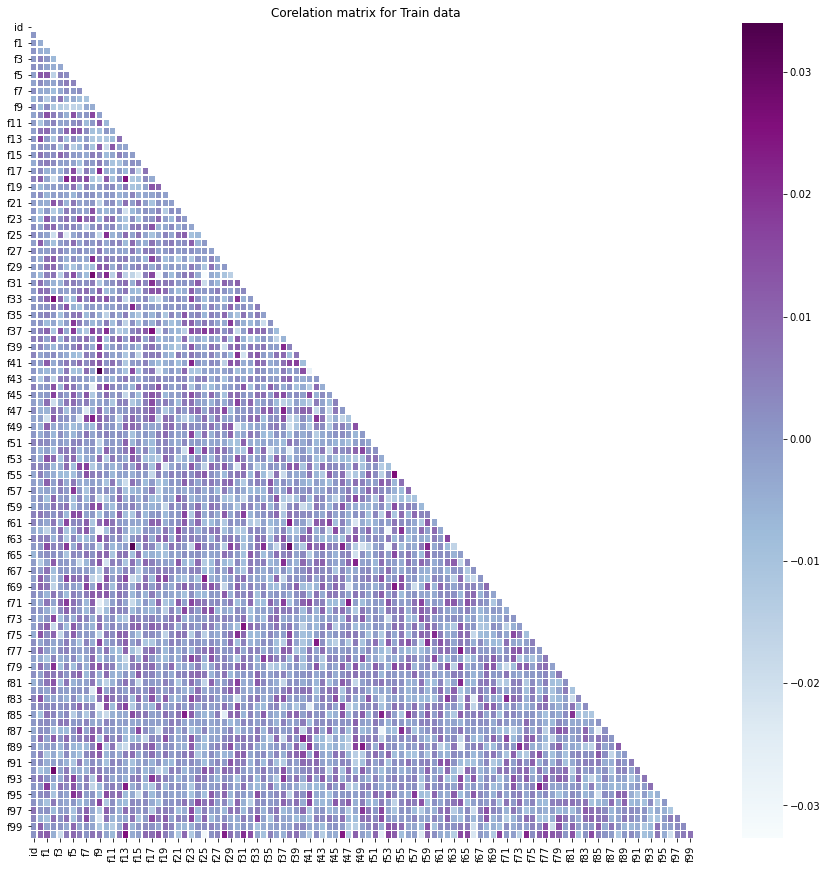

In [15]:
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))

plt.figure(figsize = (15, 15))
plt.title('Corelation matrix for Train data')
sns.heatmap(corr, mask = mask, cmap = 'BuPu', linewidths = .5)
plt.show()

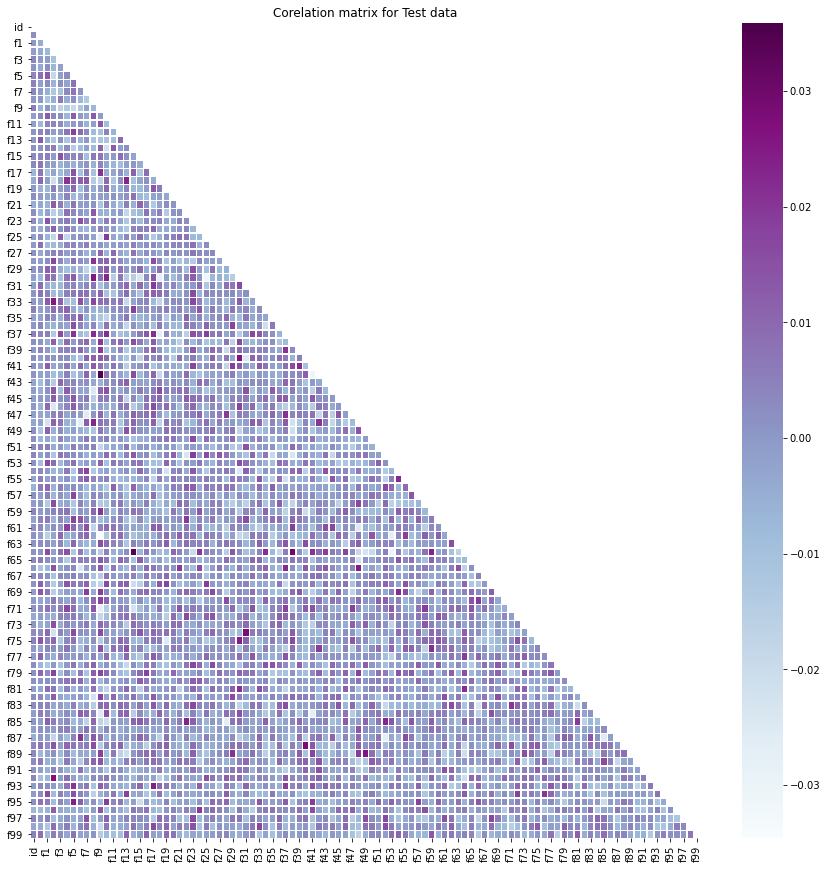

In [16]:
corr = test.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))

plt.figure(figsize = (15, 15))
plt.title('Corelation matrix for Test data')
sns.heatmap(corr, mask = mask, cmap = 'BuPu', linewidths = .5)
plt.show()

In [17]:
y = train['loss']
train.drop(['id','loss'],axis=1,inplace=True)
test.drop(['id'],axis=1,inplace=True)

In [18]:
not_features = ['id','loss']
features = []
for feat in train.columns:
    if feat not in not_features:
        features.append(feat)
        
print(features)

['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99']


In [19]:
scaler = StandardScaler()
train[features] = scaler.fit_transform(train[features])
test[features] = scaler.transform(test[features])

In [20]:
train.head()

f0        f1        f2        f3        f4        f5        f6  \
0 -1.668045  0.179768  0.498854 -1.767452 -0.585085  1.548611 -0.731714   
1  0.887510  2.208234 -0.431857 -0.732528  3.907814 -0.863906 -0.021877   
2 -0.628150 -0.763705 -0.408204 -0.546028 -0.364251  2.101452 -0.727663   
3 -0.975889 -0.810879 -0.547278  1.131234 -0.611685 -0.753071  0.113171   
4 -0.232366 -0.740119  0.651167 -0.179911 -0.579810  0.748861 -0.503574   

         f7        f8        f9  ...       f90       f91       f92       f93  \
0  1.096083 -0.163171 -0.996718  ... -0.459258 -0.576275  0.287884 -0.636568   
1  0.556142 -0.129652  0.912720  ... -0.973052 -0.592941 -0.988442 -0.360043   
2 -1.095000  0.178041  0.518736  ... -0.550573 -0.570408  0.985834  1.358390   
3  1.238672 -0.643465 -0.993810  ... -0.549438 -0.570146 -1.478323 -0.595755   
4 -0.749140  0.077481 -0.891402  ... -0.117935 -0.537094 -0.469704 -0.327684   

        f94       f95       f96       f97       f98       f99  
0  1.048811 -0.066279 -0.659995  1.706200  1.113531  0.432237  
1 -0.977224 -0.390478 -1.790770 -0.433968  1.218930 -1.222692  
2  0.439352 -0.101587 -0.224966  0.917008  0.185501  0.753750  
3  0.744873 -1.272692  0.235002  0.352117 -0.186368  0.350606  
4 -0.946548 -0.017820 -0.248517  1.277657  0.321752 -0.172972  

[5 rows x 100 columns]

In [21]:
x = train

In [22]:
def objective(trial,data=x,target=y):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 1000, 20000),
              'od_wait':trial.suggest_int('od_wait', 500, 2000),
             'loss_function':'RMSE',
              'task_type':"GPU",
              'eval_metric':'RMSE',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.02,1),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,15),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
               }
    model = CatBoostRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)
    loss = np.sqrt(mean_squared_error(y_test, y_preds))
    
    return loss

In [23]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-08-17 08:05:42,624] A new study created in memory with name: no-name-f10bc3a4-a260-4636-aacb-1a28876428c5
[I 2021-08-17 08:05:44,929] Trial 0 finished with value: 7.8903923791308035 and parameters: {'iterations': 6410, 'od_wait': 564, 'learning_rate': 0.9952644312927666, 'reg_lambda': 91.19542037977524, 'subsample': 0.498255100134697, 'random_strength': 26.787991745263508, 'depth': 5, 'min_data_in_leaf': 10, 'leaf_estimation_iterations': 14}. Best is trial 0 with value: 7.8903923791308035.
[I 2021-08-17 08:05:47,940] Trial 1 finished with value: 7.888361264924058 and parameters: {'iterations': 6840, 'od_wait': 731, 'learning_rate': 0.29750649349229374, 'reg_lambda': 60.20911292899964, 'subsample': 0.20616745097530753, 'random_strength': 14.532318185056784, 'depth': 9, 'min_data_in_leaf': 22, 'leaf_estimation_iterations': 9}. Best is trial 1 with value: 7.888361264924058.
[I 2021-08-17 08:05:52,954] Trial 2 finished with value: 7.929885862185716 and parameters: {'iterations': 15

Number of finished trials: 50
Best trial: score 7.835039085439764, params {'iterations': 13381, 'od_wait': 805, 'learning_rate': 0.02068781330759975, 'reg_lambda': 25.94804071160881, 'subsample': 0.40660586505195573, 'random_strength': 18.94090021595418, 'depth': 6, 'min_data_in_leaf': 13, 'leaf_estimation_iterations': 4}


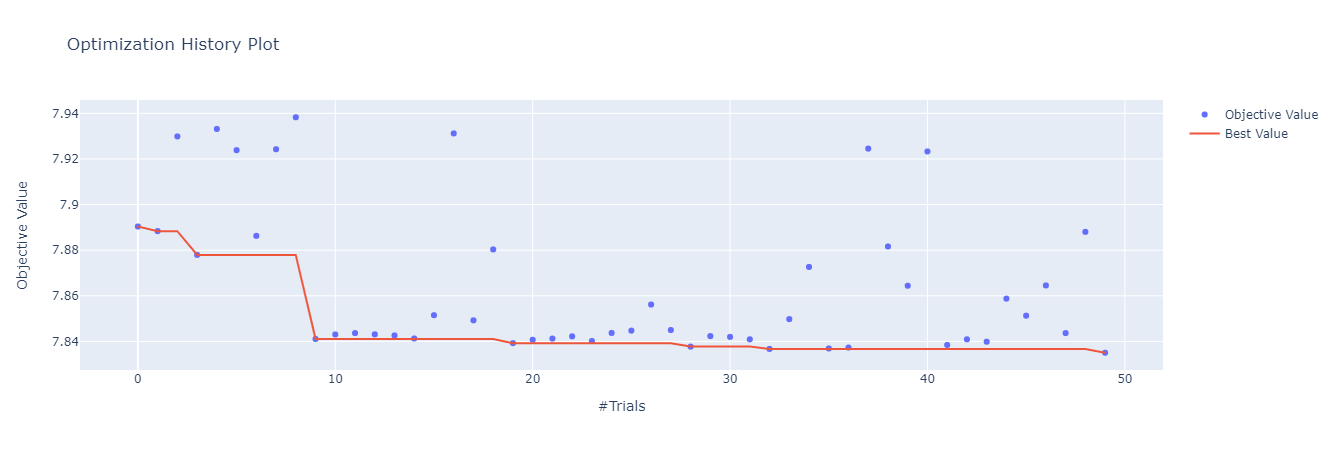

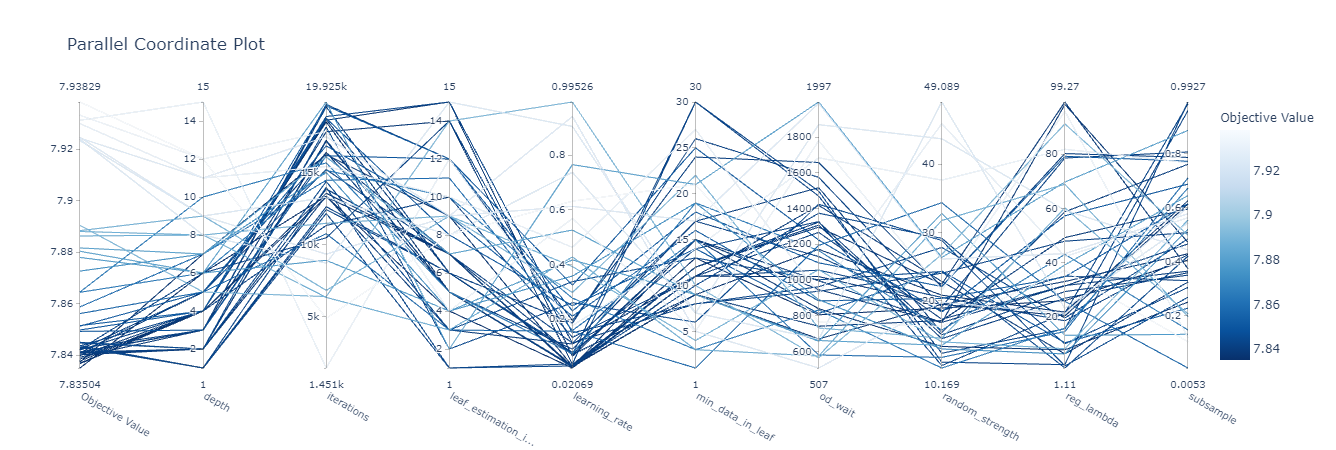

In [24]:
if OPTUNA_OPTIMIZATION:
    display(optuna.visualization.plot_optimization_history(study))
    display(optuna.visualization.plot_slice(study))
    display(optuna.visualization.plot_parallel_coordinate(study))

In [25]:
cat_params = study.best_trial.params
cat_params['loss_function'] = 'RMSE'
cat_params['eval_metric'] = 'RMSE'
cat_params['bootstrap_type']= 'Bernoulli'
cat_params['leaf_estimation_method'] = 'Newton'
cat_params['random_state'] = 42
cat_params['task_type']='GPU'
test_preds=None

print("\033[93mTraining........")

kf = StratifiedKFold(n_splits = 10 , shuffle = True , random_state = 42)
for fold, (tr_index , val_index) in enumerate(kf.split(x.values , y.values)):
    
    print("⁙" * 10)
    print(f"Fold {fold + 1}")
    
    x_train,x_val = x.values[tr_index] , x.values[val_index]
    y_train,y_val = y.values[tr_index] , y.values[val_index]
        
    eval_set = [(x_val, y_val)]
    
    model =CatBoostRegressor(**cat_params)
    model.fit(x_train, y_train, eval_set = eval_set, verbose = False)
    
    train_preds = model.predict(x_train)    
    val_preds = model.predict(x_val)
    
    print(np.sqrt(mean_squared_error(y_val, val_preds)))
    
    if test_preds is None:
        test_preds = model.predict(test.values)
    else:
        test_preds += model.predict(test.values)

print("-" * 50)
print("\033[95mTraining Done")

test_preds /= 10

Training........
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 1
7.837877851687845
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 2
7.8418222159231625
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 3
7.8448465841378825
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 4
7.832874804228045
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 5
7.844023958012642
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 6
7.839248925299925
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 7
7.8550948919883385
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 8
7.843535187823633
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 9
7.8441646368243445
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 10
7.8295917844071266
--------------------------------------------------
Training Done


In [27]:
sample_submission['loss'] = test_preds

In [28]:
sample_submission.to_csv("subcat.csv",index=False)

In [32]:
def objective2(trial,data=x,target=y):
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25,random_state=42)
    params = {
        "metric": "RMSE",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    model = lgbm.LGBMRegressor(**params,device = 'gpu',random_state=42)
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],verbose = False)
        
    y_preds = model.predict(X_test)
    loss = np.sqrt(mean_squared_error(y_test, y_preds))
    
    return loss

In [34]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble     import HistGradientBoostingRegressor

In [36]:
train_data = pd.read_csv('../../data/tabular-playground-series-aug-2021/train.csv')
test_data = pd.read_csv('../../data/tabular-playground-series-aug-2021/test.csv')
sample = pd.read_csv('../../data/tabular-playground-series-aug-2021/sample_submission.csv')

X_train = train_data.iloc[:,:-1]
y_train = train_data['loss']

regressor  =  HistGradientBoostingRegressor()
regressor.fit(X_train, y_train)

sample.iloc[:,1:] = regressor.predict(test_data)
sample.to_csv('subhgbr.csv',index=False)

In [1]:
a

NameError: name 'a' is not defined

In [4]:
pwd

'C:\\Users\\zaxir\\Documents\\my_pj\\learn\\kaggle'

In [11]:
subcat = pd.DataFrame(pd.read_csv("./TPS August2021/subcat.csv"))
subhgbr = pd.DataFrame(pd.read_csv("./TPS August2021/subhgbr.csv"))
sub_ensenble = pd.DataFrame(pd.read_csv('../../data/tabular-playground-series-aug-2021/sample_submission.csv'))

In [12]:
sub_ensenble.head()

id  loss
0  250000     0
1  250001     0
2  250002     0
3  250003     0
4  250004     0

In [13]:
sub_ensenble['loss'] = subcat['loss']*0.2 + subhgbr['loss']*0.8

In [15]:
sub_ensenble.to_csv("./TPS August2021/sub_ensenble.csv",index=False)

In [16]:
subcat.head()

id      loss
0  250000  8.149759
1  250001  4.481217
2  250002  8.298442
3  250003  7.529182
4  250004  6.902137

In [17]:
subhgbr.head()

id      loss
0  250000  7.007231
1  250001  5.086338
2  250002  6.709261
3  250003  7.262497
4  250004  8.313778

In [18]:
sub_ensenble.head()

id      loss
0  250000  7.235737
1  250001  4.965314
2  250002  7.027098
3  250003  7.315834
4  250004  8.031450

In [19]:
sub_ensenble['loss'] = (subcat['loss'] + subhgbr['loss'])/2

In [20]:
sub_ensenble.head()

id      loss
0  250000  7.578495
1  250001  4.783777
2  250002  7.503852
3  250003  7.395839
4  250004  7.607957

In [21]:
sub_ensenble.to_csv("./TPS August2021/sub_ensenble2.csv",index=False)